<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

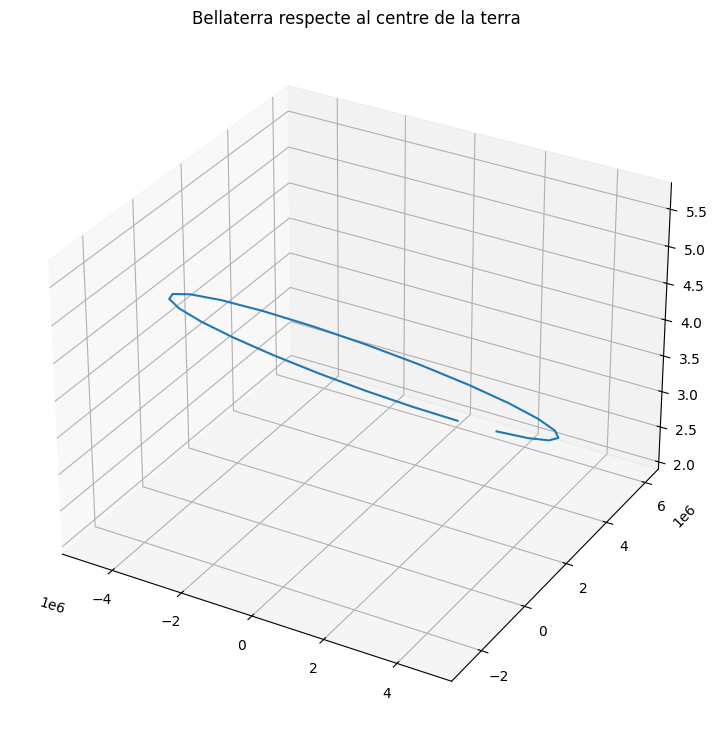

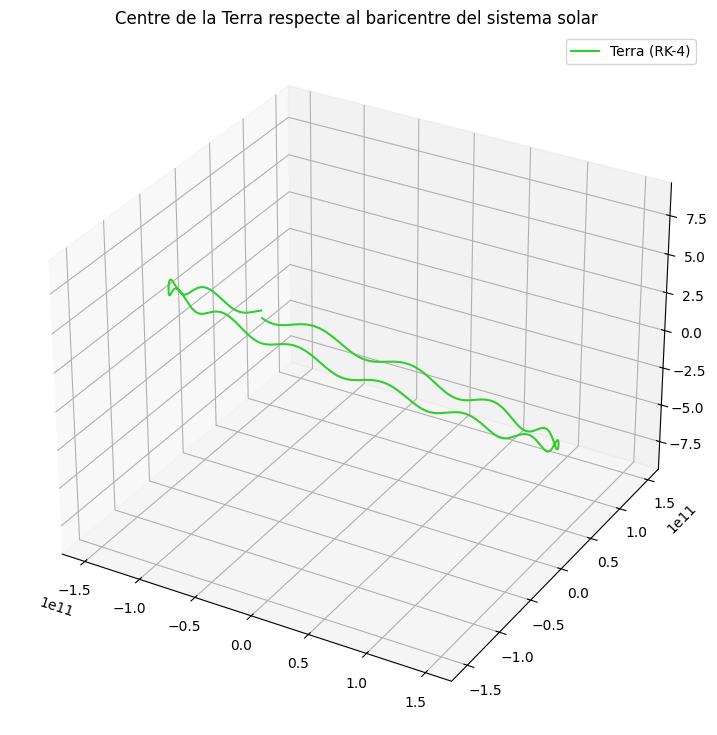

[-0.95064548 -0.92769346 -0.85973783 ... -0.75170804 -0.85996704
 -0.9278111 ]


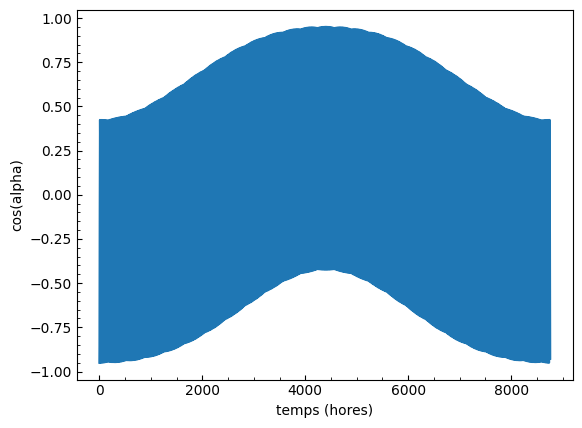

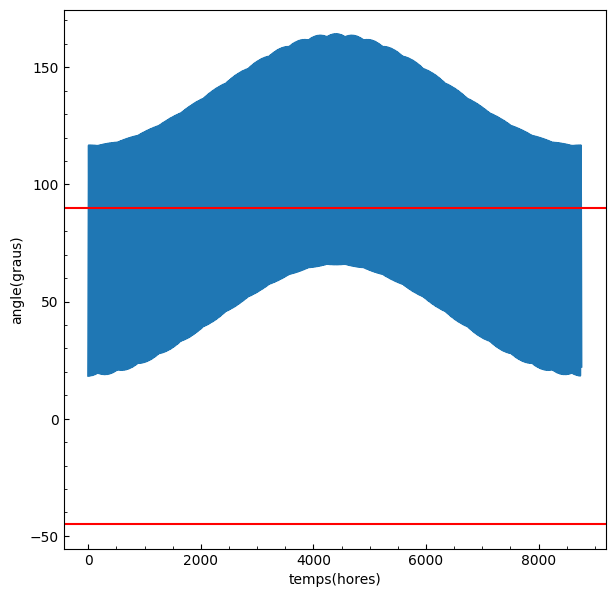

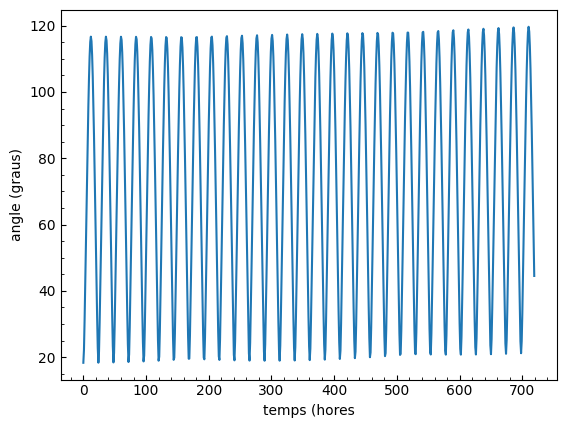

18.327112112914484 0.38229453006913916


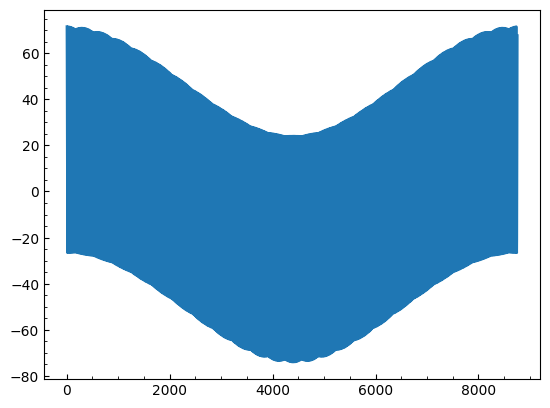

-6.389529890409506 3.163007433070021
10.975377923242334


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])
mart= np.array([-2.457240245390437E+08, -2.253913894859833E+07, 5.577461384361338E+06, 3.057555929366051E+00, -2.206677199548648E+01, -5.372712135532627E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic

def normalitza(cos):
  pos = cos[:3]*(1/r0)*10**3
  vel = cos[3:]*(t0/r0)*10**3
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0, m_mart/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
pos_mart, vel_mart= normalitza(mart)
posicions= np.array([pos_sol, pos_terra, pos_lluna, pos_mart])
velocitats= np.array([vel_sol, vel_terra, vel_lluna, vel_mart])

def acceleracions(pos, masses): # pos és una matriu de N files i 3 columnes
    N= len(masses) # Nombre de cossos: planetes, el Sol i la Lluna
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

t_f = 365
dt = 1/24
passos = int(t_f/dt) - 1

pos_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
vel_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
pos_hist[0] = posicions
vel_hist[0] = velocitats

for i in range(passos):
  pos_nou, vel_nou = rk4(pos_hist[i], vel_hist[i], masses, dt)
  pos_hist[i+1] = pos_nou
  vel_hist[i+1] = vel_nou

# Extreure trajectòries
idx_sol = 0
idx_terra = 1

x_t = pos_hist[:, idx_terra, 0]
y_t = pos_hist[:, idx_terra, 1]
z_t = pos_hist[:, idx_terra, 2]

x_s = pos_hist[:, idx_sol, 0]
y_s = pos_hist[:, idx_sol, 1]
z_s = pos_hist[:, idx_sol, 2]

# Volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

R_t = 6371000 #metres
vel_ang = 2*np.pi/24 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= (41.505833333*2*np.pi)/360

x = np.array([0])
y = np.array([R_t*np.cos(phi-theta)])
z = np.array([R_t*np.sin(phi-theta)])

t = np.linspace(1,23,23)

# Aquestes són les coordenades del vector centre terra-bellaterra
x_b = np.concatenate((x, (-1)*R_t * np.cos(phi)*np.sin(vel_ang*t)))
y_b = np.concatenate((y, (np.cos(phi-theta)*np.cos(vel_ang*t) + np.sin(theta)*(1-np.cos(vel_ang*t))*np.sin(phi)) * R_t))
z_b = np.concatenate((z, (np.sin(phi-theta)*np.cos(vel_ang*t) + np.cos(theta)*(1-np.cos(vel_ang*t))*np.sin(phi)) * R_t))

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_b,y_b,z_b)
ax.set_title("Bellaterra respecte al centre de la terra")
plt.tick_params(axis="both", direction ="in")
plt.show()

x_st = r0 * (x_t - x_s)
y_st = r0 * (y_t - y_s)
z_st = r0 * (z_t - z_s)

X_b = np.array (list(x_b)*365)
Y_b = np.array (list(y_b)*365)
Z_b = np.array (list(z_b)*365)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_st, y_st, z_st, label="Terra (RK-4)", color="limegreen")
ax.set_title("Centre de la Terra respecte al baricentre del sistema solar")
plt.tick_params(axis="both", direction ="in")
plt.legend()
plt.show()

mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
mod_b = np.sqrt(x_b**2 + y_b**2 + z_b**2)
Mod_b = np.array(list(mod_b) * 365)

cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)
cos_llista = np.clip(cos_llista, -1.0, 1.0)  # Per evitar problemes numèrics degut a que farem servir la funció arcosinus

print(cos_llista)

temps = np.linspace(0,8759,8760)

theta_llista = np.pi - np.arccos(cos_llista) #obtenim l'angle complementari que és el que ens interessa.

plt.plot (temps,cos_llista)
plt.ylabel("cos(alpha)")
plt.xlabel("temps (hores)")
plt.tick_params(axis="both", which = "both", direction ="in")
plt.minorticks_on()
plt.show()

fig = plt.figure(figsize=(7,7))
plt.plot(temps,theta_llista*365/(2*np.pi))
plt.ylabel("angle(graus)")
plt.xlabel("temps(hores)")
plt.axhline(90, color="r")
plt.axhline(-90/2,color="r")
plt.tick_params(axis="both", which = "both", direction ="in")
plt.minorticks_on()
plt.show()

plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi)) #això són els primers 11 dies pq es vegi més bé les oscil·lacions
plt.ylabel("angle (graus)")
plt.xlabel("temps (hores")
plt.tick_params(axis="both", which = "both", direction ="in")
plt.minorticks_on()
plt.show()

print(theta_llista[0] *365/(2*np.pi),theta_llista[-1])

plt.plot(np.linspace(0,8759,8760),90-(theta_llista)*365/(2*np.pi))
plt.tick_params(axis="both", which = "both", direction ="in")
plt.minorticks_on()
plt.show()


horitzo = 90-(theta_llista)*365/(2*np.pi)
print(horitzo[16],horitzo[17]) #l'index 17 conté el primer valor positu del segon dia

print(horitzo[17+723])
#nota mental aquest producte ens dona l'angle que formen dos vectors amb el mateix origen, si ens fixem nosaltres volem el complementari a aquest, és a dir pi - angle, lol


In [ ]:
theta_llista_g = theta_llista * 365 / (2 * np.pi)
print("theta_llista_degrees calculated successfully.")

theta_llista_degrees calculated successfully.


In [ ]:
creuament = 0
for i in range(len(theta_llista_g) - 1):
    if (theta_llista_g[i] < 90 and theta_llista_g[i+1] > 90) or \
       (theta_llista_g[i] > 90 and theta_llista_g[i+1] < 90):
        creuament += 1

print(f"Es creua la línia blava (dia-nit o bé nit-dia) {creuament} cops. Per tant, han passat {creuament/2} dies, que correspon a 1 any.")

Es creua la línia blava (dia-nit o bé nit-dia) 728 cops. Per tant, han passat 364.0 dies, que correspon a 1 any.


In [ ]:
index=[]
for i in range(len(horitzo) - 1):
    if horitzo[i] < 0 and horitzo[i+1] >= 0:
        index.append(i+1)
print(index)

[17, 41, 65, 89, 113, 138, 162, 186, 210, 234, 258, 282, 306, 330, 354, 378, 402, 426, 451, 475, 499, 523, 547, 571, 595, 619, 643, 667, 691, 715, 740, 764, 788, 812, 836, 860, 884, 908, 932, 956, 980, 1004, 1029, 1053, 1077, 1101, 1125, 1149, 1173, 1197, 1221, 1245, 1269, 1293, 1318, 1342, 1366, 1390, 1414, 1438, 1462, 1486, 1510, 1534, 1558, 1582, 1607, 1631, 1655, 1679, 1703, 1727, 1751, 1775, 1799, 1823, 1847, 1871, 1895, 1920, 1944, 1968, 1992, 2016, 2040, 2064, 2088, 2112, 2136, 2160, 2184, 2208, 2233, 2257, 2281, 2305, 2329, 2353, 2377, 2401, 2425, 2449, 2473, 2497, 2522, 2546, 2570, 2594, 2618, 2642, 2666, 2690, 2714, 2738, 2762, 2786, 2810, 2835, 2859, 2883, 2907, 2931, 2955, 2979, 3003, 3027, 3051, 3075, 3100, 3124, 3148, 3172, 3196, 3220, 3244, 3268, 3292, 3316, 3340, 3364, 3389, 3413, 3437, 3461, 3485, 3509, 3533, 3557, 3581, 3605, 3629, 3654, 3678, 3702, 3726, 3750, 3774, 3798, 3822, 3846, 3870, 3894, 3918, 3943, 3967, 3991, 4015, 4039, 4063, 4087, 4111, 4135, 4159, 4183, 

In [ ]:
valors=[]
hora=[]

print(horitzo[index[0]])
j=0
for j in range(24):
    if horitzo[index[0]] < 0:
      break
    valors.append(horitzo[index[28*i]+j])
    hora.append((index[28*i]+j)%24)


3.0270325786178347


IndexError: list index out of range

364
3.0270325786178347
13.169066343675837
23.88998261332975
35.01222599588641
46.31091775667938
57.33211023781826
66.87434636123768
71.64321817986624
68.01257625433232
58.92059583025824
48.042647710324246
36.77769987945976
25.635297265140082
14.853764075423982
4.608589312539394
-4.883956825284443
1.0492470206882274
11.557169789366796
22.71807665311735
34.276567527749116
45.86706888833737
56.8189779268701
65.62869786218772
69.1115201846916
65.08965163514729
56.41821004142876
46.014637530421595
35.0617710566287
24.007733212927917
13.08263199979929
2.4990030134284495
-7.445888142203216
9.151995876617391
20.890925850193412
32.65899307992018
43.90144249339354
53.72213769382853
60.5294677802425
62.1554505596
58.01263670126129
50.00805979815078
40.051977891126654
29.147779906741114
17.795071999732627
6.328693034396082
-4.9110895096093685
6.787618738453162
18.54811116676916
29.718309430454532
39.66577572113022
47.48281891493116
51.925836271855665
51.903894854752124
47.46626472054759
39.7470917

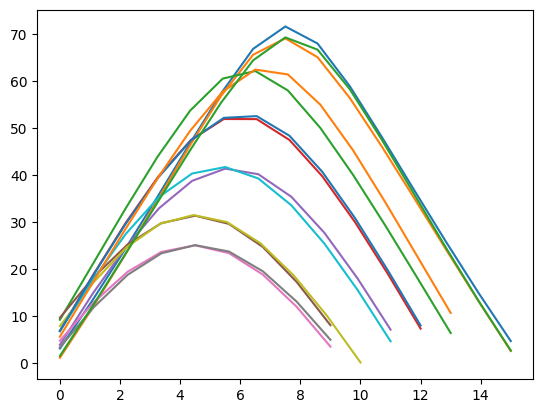

In [ ]:
print(len(index))
for i in range(13):
  valors=[]
  j=0
  while True:
    print(horitzo[index[28*i]+j])
    if horitzo[index[28*i]+j] < 0:
      break
    valors.append(horitzo[index[28*i]+j])
    j = j+ 1
  plt.plot(np.linspace(0,len(valors),len(valors)),valors)
